In [1]:
import findspark
import pandas as pd
findspark.init()

from pyspark.sql import SparkSession
from pyspark import SparkConf

# for shared metastore (shared across all users)
spark = SparkSession.builder.appName("Testing").config("hive.metastore.uris", "thrift://bialobog:9083", conf=SparkConf()).getOrCreate() \

# for local metastore (your private, invidivual database) add the following config to spark session
spark.sql("USE 2023_04_01")

AnalysisException: org.apache.hadoop.hive.ql.metadata.HiveException: java.lang.RuntimeException: Unable to instantiate org.apache.hadoop.hive.ql.metadata.SessionHiveMetaStoreClient

In [2]:
import pyspark.pandas as ps
from pyspark.sql.functions import lit,col
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import xgboost as xgb
#from boruta import BorutaPy
#from fredapi import Fred
from sklearn.linear_model import Lasso
from sklearn.model_selection import TimeSeriesSplit
import csv
from pyspark.sql import functions as F
from functools import reduce
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.linalg import Vectors, VectorUDT
from pyspark.sql.functions import udf
from pyspark.ml.regression import LinearRegression
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder, CrossValidatorModel
from CreateDataset import get_features_all_stocks_seq, get_full_series_stocks, get_tabular_dataset, get_feature_col_names, get_not_null_cols
from pyspark.sql.window import Window

/opt/spark/python/pyspark/pandas/__init__.py:50: UserWarning: 'PYARROW_IGNORE_TIMEZONE' environment variable was not set. It is required to set this environment variable to '1' in both driver and executor sides if you use pyarrow>=2.0.0. pandas-on-Spark will set it for you but it does not work if there is a Spark context already launched.
  warnings.warn(


In [3]:
def split_train_test(df, split_date):
    split_date = pd.to_datetime(split_date)
    train_df = df.filter(col('date')<split_date)
    test_df = df.filter(col('date')>=split_date)
    return train_df, test_df


def forward_fill(df):
    window_spec = Window.partitionBy('fsym_id').orderBy('date')
    feature_cols = df.columns[2:-1]
    for c in feature_cols:
        df = df.withColumn(
            c, F.last(c, ignorenulls=True).over(window_spec)
        )
    return df.orderBy('fsym_id','date')

def scale(train_df, test_df):
    window_spec = Window.partitionBy('date').orderBy('date')
    feature_cols = train_df.columns[2:-1]
    scaling_params = {}
    for c in feature_cols:
        mean_col = F.mean(F.col(c)).over(window_spec)
        stddev_col = F.stddev(F.col(c)).over(window_spec)
        epsilon = 1e-10
        train_df = train_df.withColumn(c, (F.col(c) - mean_col) / stddev_col+epsilon)
        scaling_params[c] = {'mean_col': mean_col, 'stddev_col': stddev_col+epsilon}

    for c, params in scaling_params.items():
        test_df = test_df.withColumn(c, (F.col(c) - params['mean_col']) / params['stddev_col'])

    return train_df, test_df


def write_features_file(data_list, csv_file_path='features.csv'):
    data_list = [data_list]
    with open(csv_file_path, mode='w', newline='') as file:
        writer = csv.writer(file)
        for row in data_list:
            writer.writerow(row)
    print("Features written: ", data_list[0])

    

In [4]:
def get_df(all_feats=False):

    df = get_tabular_dataset(all_feats=all_feats)

    df = forward_fill(df)
    print("Number of rows: ", df.count())
    print("Number of positives: ", df.filter(F.col('label')==1).count())
    df.show()
    df=df.na.drop()
    print("Number of rows after dropping nulls: ", df.count())
    print("Number of positives after dropping nulls: ", df.filter(F.col('label')==1).count())

    train_df, test_df = split_train_test(df, '2019-12-31')
    print(train_df.count()/df.count())
    print(test_df.count()/df.count())
    print("Number of positives in test set: ", test_df.filter(col('label')==1).count())
    train_df, test_df = scale(train_df, test_df) #introduces null values for columns that are all 0 - come back to this
    train_df = train_df.na.drop()
    test_df = test_df.na.drop()
    return train_df, test_df


In [5]:
from Boruta import BorutaPy
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier


def boruta_fs(train_df, test_df): #HOW DOES BORUTA ACC WORK?
    train_df = train_df.toPandas()
    test_df = test_df.toPandas()
    X_train = train_df.drop(['fsym_id', 'date', 'label'], axis=1)
    y_train = train_df['label']
    X_test = test_df.drop(['fsym_id', 'date', 'label'], axis=1)
    y_test = test_df['label']
    
    model = RandomForestClassifier()
    feat_selector = BorutaPy(model, n_estimators='auto', verbose=2, random_state=1)
    feat_selector.fit(X_train, y_train)
    features = X_train.columns.tolist()
    print("Number of features: ", len(features) )
    feature_ranks = list(zip(features, feat_selector.ranking_, feat_selector.support_))
    selected_features = []
    for feat in feature_ranks:
        print(f"Feature: {feat[0]}, Rank: {feat[1]}, Keep: {feat[2]}")
        if feat[1] <= 5:
            selected_features.append(feat[0])
    print("Selected features: ", selected_features)
    return selected_features


# train_df, test_df = get_df(all_feats=True)
# boruta_features = boruta_fs(train_df, test_df)
# current_features = get_feature_col_names()
# final_features = list(set(boruta_features + current_features))
# write_features_file(final_features) #in the feature selection pipeline, 

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def correlation_matrix(df):
    df =df.toPandas()
    print("Converted to Pandas")
    corr_df = df.drop(['date','fsym_id'], axis=1)
    corr_mat = corr_df.corr()
    mask = np.triu(np.ones_like(corr_mat))
    plt.figure(figsize=(50, 40))
    sns.heatmap(corr_mat, annot=True, cmap='coolwarm', fmt=".2f", mask=mask)
    plt.title('Correlation Matrix Heatmap')
    plt.tight_layout()
    plt.savefig('corr_matrix.png')
    plt.close()
    
    print("Variable pairs with absolute correlation above 0.7:")
    for i in range(len(corr_mat.columns)):
        for j in range(i+1, len(corr_mat.columns)):
            if abs(corr_mat.iloc[i, j]) >= 0.7:
                print(f"{corr_mat.columns[i]} - {corr_mat.columns[j]}: {corr_mat.iloc[i, j]}")
                
train_df, test_df = get_df()
correlation_matrix(train_df)

Number of rows:  114217
Number of positives:  553
+--------+----------+----------------------+-----------------+---------------+-----------------+-----------+----------------------+-----------------+-----------------+-----------------+--------+------------------+-------------------+------------------+--------------------------+-------+------------+--------------+----------------+----------+-----------------+----------+-----------------+-------------------+----------+-------------------+-----------------+--------------------+-----+
| fsym_id|      date|ff_net_inc_bef_xord_gr|  ff_capex_assets|ff_div_yld_secs|          ff_roic|ff_earn_yld|ff_debt_st_x_curr_port|          ff_roce|   ff_oper_inc_gr| ff_reinvest_rate|ff_wkcap|ff_commiss_inc_net|ff_oper_cf_fix_chrg|ff_debt_entrpr_val|ff_net_inc_dil_bef_unusual|ff_xord|ff_xord_disc|ff_liabs_lease| ff_pfd_stk_tcap|ff_div_yld| ff_gross_cf_debt|ff_dil_adj|      ff_sales_gr| ff_net_inc_per_emp|ff_fcf_yld|    ff_non_oper_exp|       ff_roa_ptx|ff_d

In [7]:
train_df = train_df.drop('ff_div_yld_secs', 'ff_earn_yld', 'ff_roa_ptx')
test_df = test_df.drop('ff_div_yld_secs', 'ff_earn_yld', 'ff_roa_ptx')

Features:  ['ff_net_inc_bef_xord_gr', 'ff_capex_assets', 'ff_roic', 'ff_debt_st_x_curr_port', 'ff_roce', 'ff_oper_inc_gr', 'ff_reinvest_rate', 'ff_wkcap', 'ff_commiss_inc_net', 'ff_oper_cf_fix_chrg', 'ff_debt_entrpr_val', 'ff_net_inc_dil_bef_unusual', 'ff_xord', 'ff_xord_disc', 'ff_liabs_lease', 'ff_pfd_stk_tcap', 'ff_div_yld', 'ff_gross_cf_debt', 'ff_dil_adj', 'ff_sales_gr', 'ff_net_inc_per_emp', 'ff_fcf_yld', 'ff_non_oper_exp', 'ff_dfd_tax_assets_lt']

Results for Logistic Regression:


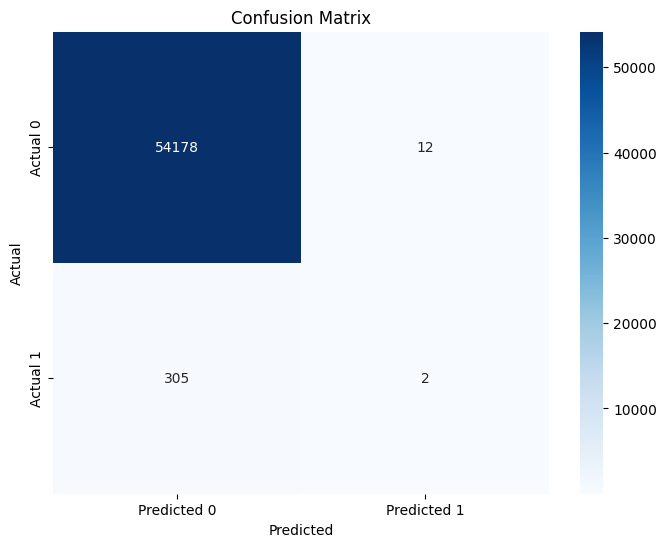

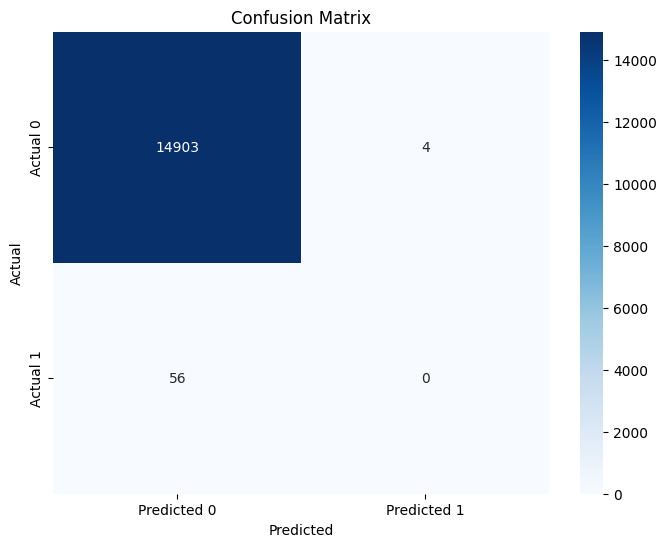


Area under the ROC curve (AUC) - Train - Logistic Regression: 0.8171127886979881
Area under the ROC curve (AUC) - Test - Logistic Regression: 0.8371474570911106

Results for Random Forest:


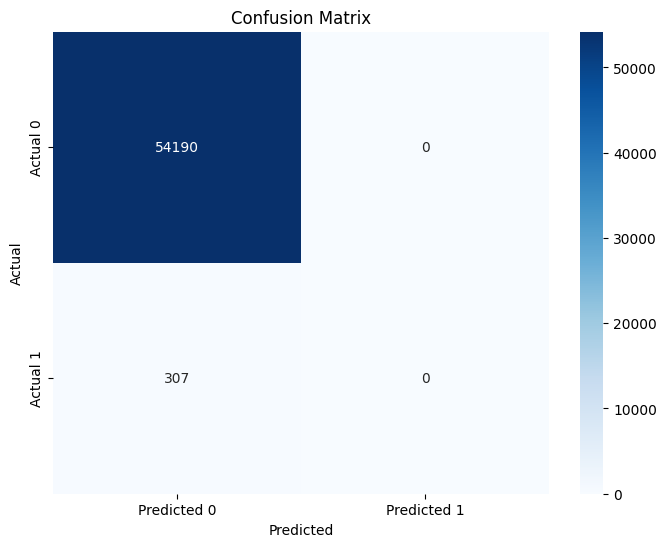

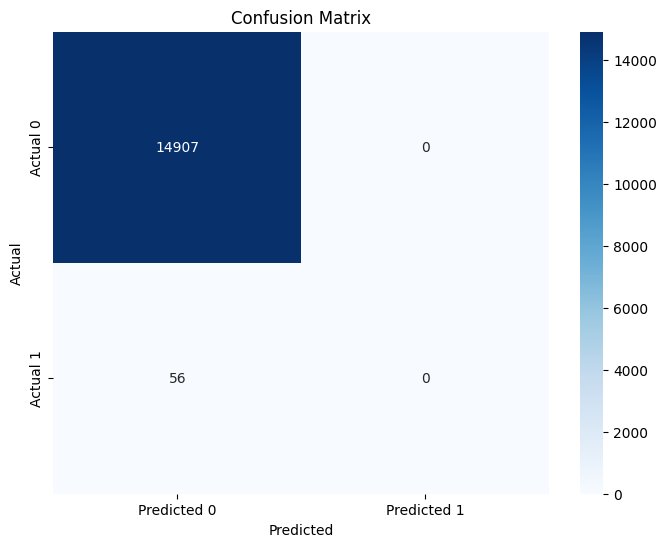


Area under the ROC curve (AUC) - Train - Random Forest: 0.9125580882322003
Area under the ROC curve (AUC) - Test - Random Forest: 0.8455112171654735

Results for Gradient Boosting:


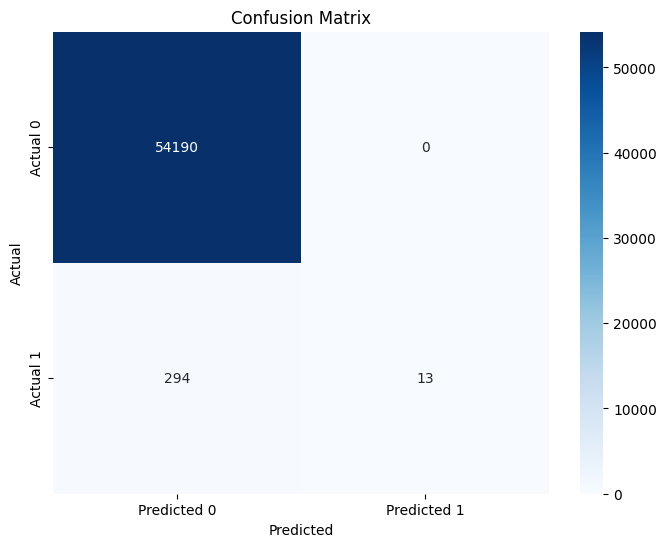

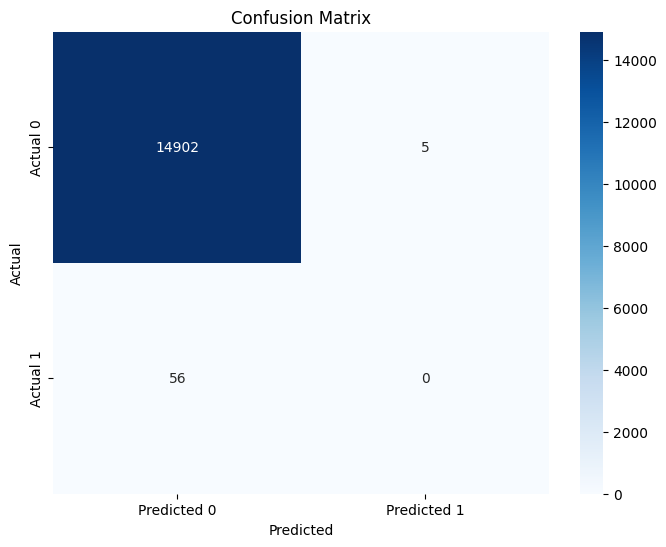


Area under the ROC curve (AUC) - Train - Gradient Boosting: 0.9658714091389146
Area under the ROC curve (AUC) - Test - Gradient Boosting: 0.8373762566004463


In [14]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.linalg import Vectors, VectorUDT
from pyspark.sql.functions import udf
from pyspark.ml.regression import LinearRegression
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder, CrossValidatorModel
from sklearn.metrics import confusion_matrix

def confusion_matrix_pandas(df):
    """
    Create a confusion matrix as a Pandas DataFrame.

    Args:
        predictions (DataFrame): DataFrame containing 'label' and 'prediction' columns.
        label_col (str): Name of the column with actual labels.
        prediction_col (str): Name of the column with predicted labels.

    Returns:
        pd.DataFrame: Confusion matrix.
    """
    df = df.toPandas()
    cm = confusion_matrix(df['label'], df['prediction'])
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
    plt.title(f'Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
    

def basic_test(train_df, test_df):
    feature_cols = train_df.columns[2:-1]
    print("Features: ", feature_cols)
    
    assembler = VectorAssembler(inputCols=feature_cols, outputCol='features')
    train_df = assembler.transform(train_df)
    test_df = assembler.transform(test_df)
    
    lr = LogisticRegression(labelCol='label', featuresCol='features')
    rf = RandomForestClassifier(featuresCol='features', labelCol='label')
    gb = GBTClassifier(labelCol='label', featuresCol='features')
    
    models = {'Logistic Regression': lr, 'Random Forest': rf, 'Gradient Boosting': gb}

    for model_name, model in models.items():
        print(f"\nResults for {model_name}:")
        trained_model = model.fit(train_df)
        
        preds_train_df = trained_model.transform(train_df)
        preds_test_df = trained_model.transform(test_df)
        #print(preds_train_df.show())
        
        # Train set confusion matrix
        confusion_matrix_pandas(preds_train_df.select('prediction', 'label'))
        
        # Test set confusion matrix
        confusion_matrix_pandas(preds_test_df.select('prediction', 'label'))
        
        # Area under the ROC curve
        evaluator = BinaryClassificationEvaluator(labelCol='label', rawPredictionCol='rawPrediction', metricName='areaUnderROC')
        auc_train = evaluator.evaluate(preds_train_df)
        auc_test = evaluator.evaluate(preds_test_df)
        
        print(f"\nArea under the ROC curve (AUC) - Train - {model_name}: {auc_train}")
        print(f"Area under the ROC curve (AUC) - Test - {model_name}: {auc_test}")
        
basic_test(train_df, test_df)

In [ ]:

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC

def cross_val(train_df, test_df):
    feature_cols = train_df.columns[2:-1]
    print("Features: ",feature_cols)
    assembler = VectorAssembler(inputCols=feature_cols, outputCol='features')
    lr = LogisticRegression(labelCol='label', featuresCol = 'features')
    rf = RandomForestClassifier(featuresCol="features", labelCol="label")
    gb = GBTClassifier(labelCol='label', featuresCol = 'features')
    
    classifiers = [lr, rf, gb]
    
    cv_models = []
    
    evaluator = BinaryClassificationEvaluator(labelCol='label', rawPredictionCol="rawPrediction", metricName='areaUnderROC')
    
    for classifier in classifiers:
        print("Starting...")
        pipeline = Pipeline(stages=[assembler, classifier])
        
        paramGrid = ParamGridBuilder() \
        .addGrid(classifier.regParam, [0.01, 0.1]) \
        .addGrid(classifier.elasticNetParam, [0.0, 0.5]) \
        .addGrid(classifier.maxIter, [10, 20]) \
        .build()
        
        cross_val = CrossValidator(
            estimator=pipeline,
            estimatorParamMaps=paramGrid,
            evaluator=evaluator,
            numFolds=5
        )
        
        cv_model = cross_val.fit(train_df)
        cv_models.append(cv_model)
        print("Working")
    
    for cv_model in cv_models:
        predictions = cv_model.transform(test_df)
        auc = evaluator.evaluate(predictions)
        print(f"Model AUC: {auc}")
        
def basic_test(train_df, test_df):
    feature_cols = train_df.columns[2:-1]
    print("Features: ",feature_cols)
    assembler = VectorAssembler(inputCols=feature_cols, outputCol='features')
    train_df = assembler.transform(train_df)
    test_df = assembler.transform(test_df)
    lr = LogisticRegression(labelCol='label', featuresCol = 'features')
    rf = RandomForestClassifier(featuresCol="features", labelCol="label")
    gb = GBTClassifier(labelCol='label', featuresCol = 'features')
    
    evaluator = BinaryClassificationEvaluator(labelCol='label', rawPredictionCol="rawPrediction", metricName='areaUnderROC')
    
    lr = lr.fit(train_df)
    preds_train_df = lr.transform(train_df)
    preds_test_df = lr.transform(test_df)
    
    
def cross_val_pandas(train_df, test_df):
    train_df = train_df.toPandas()
    test_df = test_df.toPandas()
    print("Converted to Pandas")
    exclude_columns = ['fsym_id', 'date', 'label']
    
    X_train = train_df.drop(exclude_columns, axis=1)
    y_train = train_df['label']
    X_test = test_df.drop(exclude_columns, axis=1)
    y_test = test_df['label']
    models = {
        'Logistic Regression': LogisticRegression(),
        'Random Forest': RandomForestClassifier(),
        'SVM': SVC(probability=True),
        'Gradient Boosting': GradientBoostingClassifier()
    }

    param_grids = {
        'Logistic Regression': {
            'C': [0.01, 0.1, 1.0, 10.0],
            'max_iter': [100, 200, 300]
        },
        'Random Forest': {
            'n_estimators': [50, 100, 200],
            'max_depth': [None, 10, 20]
        },
        'SVM': {
            'C': [0.1, 1.0, 10.0],
            'kernel': ['linear', 'rbf']
        },
        'Gradient Boosting': {
            'n_estimators': [50, 100, 200],
            'learning_rate': [0.01, 0.1, 0.2],
            'max_depth': [3, 5, 7]
        }
    }
    tscv = TimeSeriesSplit(n_splits=5)

    for model_name, model in models.items():
        param_grid = param_grids[model_name]

        grid_search = GridSearchCV(model, param_grid, cv=tscv, scoring='roc_auc')

        grid_search.fit(X_train, y_train)
        
        best_model = grid_search.best_estimator_

        predictions = best_model.predict(X_test)

        auc = roc_auc_score(y_test, predictions)

        print(f"\nResults for {model_name}:")
        print(f"Area under the ROC curve (AUC): {auc}")
        print("Best model hyperparameters:")
        print(grid_search.best_params_)
        
        # Confusion matrix
        cm = confusion_matrix(y_test, predictions)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
        plt.title(f'Confusion Matrix - {model_name}')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.show()
        

#model_testing(train_df, test_df)
#cross_val_pandas(train_df, test_df)